# logp evaluation of PAE

In [1]:
import tensorflow.compat.v1 as tf
#To make tf 2.0 compatible with tf1.0 code, we disable the tf2.0 functionalities
tf.disable_eager_execution()
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import sys
import pickle
from functools import partial


plt.rcParams.update({'font.family' : 'lmodern', 'font.size': 16,                                                                                                                                                    
                     'axes.labelsize': 16, 'legend.fontsize': 12, 
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'axes.titlesize': 16,
                     'axes.linewidth': 1.5}) 

In [7]:
tf.__version__

'2.2.0'

In [8]:
import scipy

In [9]:
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors

In [10]:
tfp.__version__

'0.7.0'

In [11]:
from pae.model_tf2 import get_prior, get_posterior

In [12]:
import pae.create_datasets as crd
import pae.load_data as ld
load_funcs=dict(mnist=ld.load_mnist, fmnist=ld.load_fmnist)

In [13]:
PROJECT_PATH = "../../" 
PARAMS_PATH = os.path.join(PROJECT_PATH,'params')

param_file  = 'params_mnist_-1_10_vae10_AE_test_full_sigma'
params      = pickle.load(open(os.path.join(PARAMS_PATH,param_file+'.pkl'),'rb'))

In [14]:
params['module_dir']='../../modules/mnist/class-1/latent_size10/net_type_vae10/loss_AE/test_full_sigma'
params['data_dir']= '../../data/'

In [15]:
load_func                                          = partial(load_funcs[params['data_set']])
x_train, y_train, x_valid, y_valid, x_test, y_test = load_func(params['data_dir'],flatten=True)

if np.all(x_test)==None:
    x_test=x_valid

x_train = x_train/256.-0.5
x_test  = x_test/256.-0.5
x_valid = x_valid/256.-0.5

In [16]:
generator_path   = os.path.join(params['module_dir'],'decoder')
encoder_path     = os.path.join(params['module_dir'],'encoder')
nvp_path         = os.path.join(params['module_dir'],'hybrid8_nepoch220')

In [17]:
def get_likelihood(decoder,sigma):
  
    def likelihood(z):
        mean = decoder({'z':z},as_dict=True)['x']
        return tfd.Independent(tfd.MultivariateNormalDiag(loc=mean,scale_diag=sigma))

    return likelihood

In [18]:
x             = tf.placeholder(shape=[params['batch_size'],params['output_size']],dtype=tf.float32)
value         = tf.placeholder_with_default(tf.zeros((params['batch_size'],params['latent_size']),tf.float32),shape=(params['batch_size'],params['latent_size']))
z             = tf.Variable(initial_value=tf.zeros((params['batch_size'],params['latent_size']),tf.float32), trainable=True)

encoder       = hub.Module(encoder_path, trainable=False)
decoder       = hub.Module(generator_path, trainable=False)

encoded       = encoder({'x':x},as_dict=True)['z']
decoded       = decoder({'z':z},as_dict=True)['x']

update        = z.assign(value)
nvp_funcs     = hub.Module(nvp_path, trainable=False)
sigma         = tf.placeholder_with_default(params['full_sigma'],shape=[params['output_size']])
sigma         = tf.cast(sigma,tf.float32)


likelihood    = get_likelihood(decoder,sigma)
prior         = get_prior(params['latent_size'])

def likelihood_eval(z,x,likelihood):
    likelihood    = likelihood(z).log_prob(x)
    return likelihood

def prior_eval(z,nvp_funcs=nvp_funcs):
    prior         = nvp_funcs({'z_sample':z,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))},as_dict=True)['log_prob']
    return prior

def posterior_eval(z,x,likelihood, nvp_funcs):
    likelihood   = likelihood_eval(z,x,likelihood)
    prior        = prior_eval(z, nvp_funcs)
    logprob      = likelihood+prior
    return logprob

logp  = posterior_eval(z,x,likelihood,nvp_funcs)
loss  = -logp
grad  = tf.gradients(loss, [z])


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Instructions for updating:
Do not call `graph_parents`.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [19]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [20]:
def neg_logp(z_):
    z_fill    = np.zeros((params['batch_size'], params['latent_size']), dtype=np.float32)
    z_fill[0] = z_
    _      = sess.run(update, feed_dict={value:z_fill,x:x_valid[0:16]})
    ll     = sess.run(loss, feed_dict={value:z_fill,x:x_valid[0:16]})
    return np.asarray(ll, dtype=np.float64)[0]

def neg_logp_grad(z_):
    z_fill = np.zeros((params['batch_size'], params['latent_size']), dtype=np.float32)
    z_fill[0] = z_
    _      = sess.run(update, feed_dict={value:z_fill,x:x_valid[0:16]})
    gg = sess.run(grad, feed_dict={z:z_fill,x:x_valid[0:16]})
    #print(gg[0].shape)
    return np.asarray(-gg[0][0], dtype=np.float64)

In [21]:
from scipy.optimize import minimize

In [22]:
enc = sess.run(encoded, feed_dict={x:x_valid[0:16]})[:,0:10]

In [23]:
neg_logp(enc[0:1])

-1763.1529541015625

Full Measured Sigma, log_post with single sample, Log Likelihood at Encoded and Reconstruction

In [24]:
minimum = neg_logp(enc[0])
best_z  = enc[0]
for ii in range(10):
    print(ii)
    init = enc[0]+(np.random.randn(np.prod(enc[0].shape))*0.02).reshape(enc[0].shape)
    res = scipy.optimize.minimize(neg_logp, x0=init, jac=neg_logp_grad, method='L-BFGS-B',tol=None, callback=None, options={'disp': None, 'maxcor': 10, 'ftol': 2.220446049250313e-09, 'gtol': 1e-08, 'eps': 1e-09, 'maxfun': 15000, 'maxiter': 15000, 'iprint': - 1, 'maxls': 20})
    if res['fun']<minimum:
        best_z  = res['x']
        minimum = res['fun']
        print('new minimum found:', res['success'])
        

0
1
2
new minimum found: False
3
4
5
6
7
8
9


In [25]:
print(minimum)

-1763.3643798828125


In [26]:
z_fill    = np.zeros((params['batch_size'], params['latent_size']))
z_fill[0] = best_z
sess.run(update, feed_dict={value:z_fill})
x_esti= sess.run(decoded, feed_dict={value:z_fill})[0,:]

In [27]:
z_fill    = np.zeros((params['batch_size'], params['latent_size']))
z_fill[0] = enc[0]
sess.run(update, feed_dict={value:z_fill})
x_enc= sess.run(decoded, feed_dict={value:z_fill})[0,:]

findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.


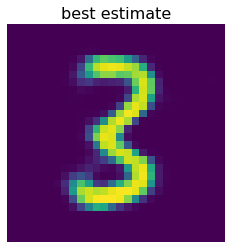

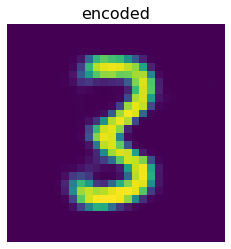

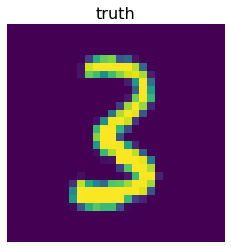

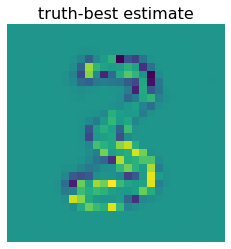

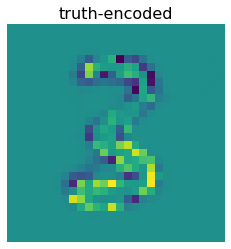

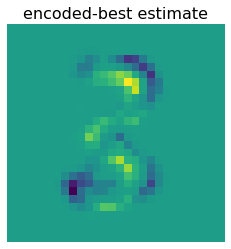

In [28]:
plt.title('best estimate')
plt.imshow(x_esti.reshape(28,28))
plt.axis('off')
plt.show()
plt.title('encoded')
plt.imshow(x_enc.reshape(28,28))
plt.axis('off')
plt.show()
plt.title('truth')
plt.imshow(x_valid[0].reshape(28,28))
plt.axis('off')
plt.show()
plt.title('truth-best estimate')
plt.imshow(x_valid[0].reshape(28,28)-x_esti.reshape(28,28))
plt.axis('off')
plt.show()
plt.title('truth-encoded')
plt.imshow(x_valid[0].reshape(28,28)-x_enc.reshape(28,28))
plt.axis('off')
plt.show()
plt.title('encoded-best estimate')
plt.imshow(x_enc.reshape(28,28)-x_esti.reshape(28,28))
plt.axis('off')
plt.show()

In [70]:
import autograd.numpy as np
import numpy.linalg as linalg
from autograd import grad

# toy example
means = [np.asarray([1.,-4.]), np.asarray([-2.,2.])]
covs  = [np.asarray([[2.,-0.5,],[-0.5,2]]),np.asarray([[2,0.5],[0.5,2]])]
weights = [0.5,0.5]

# checking for pos def
for cov in covs:
    _ = linalg.cholesky(cov)
    
def create_neg_log_prob(means, covs,weights):
    
    def negative_log_prob(x):
        gs = []
        N  = means[0].shape[0]
        for mean,cov in zip(means,covs):
            m = (x-mean)
            _, det= np.linalg.slogdet(cov)
            gs+=[-0.5*np.dot(m,np.dot(cov,m))-N/2.*np.log(2*np.pi)-N*det]
        res = gs[0]+weights[0]
        for ii, w in enumerate(weights[1::]):
            res=np.logaddexp(res,w+gs[ii+1])
        return -res
    return negative_log_prob

negative_log_prob      = create_neg_log_prob(means,covs,weights)
negative_log_prob_grad = grad(negative_log_prob)

In [52]:
from nuts import nuts6, NutsSampler_fn_wrapper
import time

In [53]:
#NUTS pars
M, Madapt = 100, 500
theta0    = np.asarray([0.,0.])
delta     = 1

nuts_fn = NutsSampler_fn_wrapper(negative_log_prob, negative_log_prob_grad)
#nuts_fn.verbose = True

t_start = time.time()
print("Starting Sampling at %s" % time.ctime(t_start))
A, lnprob, epsilon = nuts6(nuts_fn, M, Madapt, theta0, delta)
t_stop = time.time()
print("Sampling Completed in %0.2f seconds" % (t_stop - t_start))

Starting Sampling at Fri Oct  9 08:12:30 2020
find_reasonable_epsilon= 0.25
Sampling Completed in 5.24 seconds


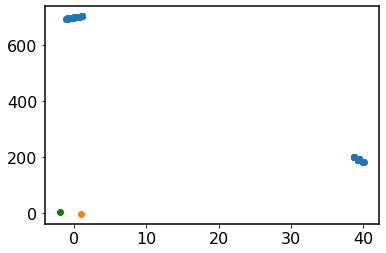

In [54]:
plt.scatter(A[:,0],A[:,1])
plt.scatter(means[0][0], means[0][1])
plt.scatter(means[1][0], means[1][1], color='g')
plt.show()

In [101]:
class DualAveragingStepSize:
    def __init__(self, initial_step_size, target_accept=0.65, gamma=0.05, t0=10.0, kappa=0.75):
        self.mu            = np.log(10 * initial_step_size)  # proposals are biased upwards to stay away from 0.
        self.target_accept = target_accept
        self.gamma         = gamma
        self.t             = t0
        self.kappa         = kappa
        self.error_sum     = 0
        self.log_averaged_step = 0

    def update(self, p_accept):
        # Running tally of absolute error. Can be positive or negative. Want to be 0.
        self.error_sum += self.target_accept - p_accept
        
        #print(self.error_sum)

        # This is the next proposed (log) step size. Note it is biased towards mu.
        log_step = self.mu - self.error_sum / (np.sqrt(self.t) * self.gamma)

        # Forgetting rate. As `t` gets bigger, `eta` gets smaller.
        eta = self.t ** -self.kappa

        # Smoothed average step size
        self.log_averaged_step = eta * log_step + (1 - eta) * self.log_averaged_step

        # This is a stateful update, so t keeps updating
        self.t += 1

        # Return both the noisy step size, and the smoothed step size
        return np.exp(log_step), np.exp(self.log_averaged_step)

In [102]:
import scipy.stats as st
from tqdm import tqdm

def leapfrog(q, p, dVdq, path_len, step_size):
    """Leapfrog integrator for Hamiltonian Monte Carlo.

    Parameters
    ----------
    q : np.floatX
        Initial position
    p : np.floatX
        Initial momentum
    dVdq : callable
        Gradient of the velocity
    path_len : float
        How long to integrate for
    step_size : float
        How long each integration step should be

    Returns
    -------
    q, p : np.floatX, np.floatX
        New position and momentum
    """
    q, p = np.copy(q), np.copy(p)

    p -= step_size * dVdq(q) / 2  # half step
    for _ in range(int(path_len / step_size) - 1):
        q += step_size * p  # whole step
        p -= step_size * dVdq(q)  # whole step
    q += step_size * p  # whole step
    p -= step_size * dVdq(q) / 2  # half step

    # momentum flip at end
    return q, -p


In [110]:
def hamiltonian_monte_carlo(n_samples, negative_log_prob, dVdq , initial_position, path_len=1, step_size=0.05, tune=500):
    """Run Hamiltonian Monte Carlo sampling.

    Parameters
    ----------
    n_samples : int
        Number of samples to return
    negative_log_prob : callable
        The negative log probability to sample from
    initial_position : np.array
        A place to start sampling from.
    path_len : float
        How long each integration path is. Smaller is faster and more correlated.
    step_size : float
        How long each integration step is. Smaller is slower and more accurate.

    Returns
    -------
    np.array
        Array of length `n_samples`.
    """

    # collect all our samples in a list
    samples = [initial_position]

    # Keep a single object for momentum resampling
    momentum = st.norm(0, 1)

    # If initial_position is a 10d vector and n_samples is 100, we want
    # 100 x 10 momentum draws. We can do this in one call to momentum.rvs, and
    # iterate over rows
    size = (n_samples,) + initial_position.shape[:1]
    step_size_tuning = DualAveragingStepSize(initial_step_size=step_size)
    
    for idx, p0 in tqdm(enumerate(momentum.rvs(size=size)), total=size[0]):
        # Integrate over our path to get a new position and momentum
        q_new, p_new = leapfrog(
            samples[-1],
            p0,
            dVdq,
            path_len=path_len,
            step_size=step_size,
        )
        
#     size = (n_samples,) + initial_position.shape[:1]
#     for p0 in momentum.rvs(size=size):
#         # Integrate over our path to get a new position and momentum
#         q_new, p_new = leapfrog(
#             samples[-1],
#             p0,
#             dVdq,
#             path_len=path_len,
#             step_size=step_size,
#         )

        # Check Metropolis acceptance criterion
        start_log_p = negative_log_prob(samples[-1]) - np.sum(momentum.logpdf(p0))
        new_log_p   = negative_log_prob(q_new) - np.sum(momentum.logpdf(p_new))
        p_accept    = np.exp(start_log_p - new_log_p)
        if np.log(np.random.rand()) < start_log_p - new_log_p:
            samples.append(q_new)
        else:
            samples.append(np.copy(samples[-1]))

        # Check Metropolis acceptance criterion
#         start_log_p = negative_log_prob(samples[-1]) - np.sum(momentum.logpdf(p0))
#         new_log_p   = negative_log_prob(q_new) - np.sum(momentum.logpdf(p_new))
        
#         p_accept = min(1, np.exp(new_log_p - start_log_p))
#         rand_num = np.random.rand()
#         if rand_num < p_accept:
#             samples.append(q_new)
#             print(p_accept,rand_num, q_new, step_size)
#         else:
#             samples.append(np.copy(samples[-1]))
            
        # Tuning routine
        if idx < tune - 1:
            step_size, _ = step_size_tuning.update(p_accept)
        elif idx == tune - 1:
            _, step_size = step_size_tuning.update(p_accept)
            print(step_size)
    return np.array(samples[1+tune:])

In [111]:
t_start=time.time()
samples= hamiltonian_monte_carlo(n_samples=10000, negative_log_prob=negative_log_prob, dVdq=negative_log_prob_grad , initial_position=np.asarray([0.,0.]), path_len=10, step_size=0.5)
t_stop = time.time()
print("Sampling Completed in %0.2f seconds" % (t_stop - t_start))

  5%|▌         | 526/10000 [00:04<01:13, 128.34it/s]

1.0665176225572832


100%|██████████| 10000/10000 [01:18<00:00, 127.84it/s]

Sampling Completed in 78.27 seconds


In [112]:
samples

array([[-1.81011143,  2.90280708],
       [-1.81011143,  2.90280708],
       [-1.81011143,  2.90280708],
       ...,
       [-0.29788997, -5.35270079],
       [-0.29788997, -5.35270079],
       [-0.55437581, -5.17924182]])

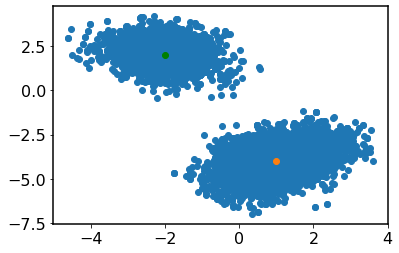

In [113]:
plt.scatter(samples[:,0],samples[:,1])
plt.scatter(means[0][0], means[0][1])
plt.scatter(means[1][0], means[1][1], color='g')
plt.show()